# VGGNet Covid-19 Classification Model

# Import Libraries

In [5]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# libraries for files preparation
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import shutil

# libraries for CNN models and plotting
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [7]:
# Check if GPU is detected by Tensorflow
print(tf.config.list_physical_devices('GPU'))

[]


In [8]:
# Helps avoid clutter of old models and layers when runnning with limited memory
tf.keras.backend.clear_session()

# Data Sampling

In [9]:
# install openpyxl to read excel files
!pip install openpyxl


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
# Change to corresponding dataset directory
path = 'C:/TDS3651/Project'

train_dir = path + '/Train'
val_dir = path + '/Validate'

train_covid = train_dir + '/covid'
train_normal = train_dir + '/normal'

val_covid = val_dir + '/covid'
val_normal  = val_dir + '/normal'

In [11]:
# Emptying the training and validation folders before copying new images into them
for filename in os.listdir(train_covid):
    if filename.endswith('.png'):
        os.remove(os.path.join(train_covid,filename))

for filename in os.listdir(train_normal):
    if filename.endswith('.png'):
        os.remove(os.path.join(train_normal,filename))

for filename in os.listdir(val_covid):
    if filename.endswith('.png'):
        os.remove(os.path.join(val_covid,filename))
        
for filename in os.listdir(val_normal):
    if filename.endswith('.png'):
        os.remove(os.path.join(val_normal,filename))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/TDS3651/Project/Train/covid'

In [ ]:
# Check if the folders in train_dir exist
os.listdir(train_dir)

['covid', 'normal']

In [ ]:
covid = pd.read_excel(path + '/COVID-19_Radiography_Dataset/COVID.metadata.xlsx')
covid.head()

,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


In [ ]:
normal = pd.read_excel(path + '/COVID-19_Radiography_Dataset/Normal.metadata.xlsx')
normal.head()

,FILE NAME,FORMAT,SIZE,URL
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,NORMAL-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,NORMAL-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [ ]:
# Check the number of each cases
print("Covid cases: ", str(len(covid)))
print("Normal cases: ", str(len(normal)))

Covid cases:  3616
Normal cases:  10192


In [ ]:
# Sample size is set to the lowest amount of all the classes, which is 3616.
SAMPLE_SIZE = 3616

In [ ]:
# Add a unique label for each case
covid['label'] = 0
normal['label'] = 1

In [ ]:
# Get only the filename and label columns of the dataframe
covid = covid[['FILE NAME', 'label']]
normal = normal[['FILE NAME', 'label']]

In [ ]:
# Take a look at covid dataframe
covid.head()

,FILE NAME,label
0,COVID-1,0
1,COVID-2,0
2,COVID-3,0
3,COVID-4,0
4,COVID-5,0


In [ ]:
# sampling data for covid and normal cases
df_0 = covid.sample(SAMPLE_SIZE, random_state=26)
df_1 = normal.sample(SAMPLE_SIZE, random_state=26)

# concat dataframes
data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

# check numbers of each label
data['label'].value_counts()

0    3616
1    3616
Name: label, dtype: int64

In [ ]:
# shuffle data
data = shuffle(data)
data.head()

,FILE NAME,label
383,COVID-521,0
3190,COVID-561,0
4582,NORMAL-498,1
599,COVID-2121,0
4490,NORMAL-1298,1


## Train Test Split

In [ ]:
df_train, df_val = train_test_split(data, test_size=0.20, random_state=26, stratify=data['label'])

print(df_train.shape)
print(df_val.shape)

(5785, 2)
(1447, 2)


In [ ]:
df_train['label'].value_counts()

0    2893
1    2892
Name: label, dtype: int64

In [ ]:
df_val['label'].value_counts()

1    724
0    723
Name: label, dtype: int64

## Transfer Images into Folders

In [ ]:
train_list = list(df_train['FILE NAME'])
val_list = list(df_val['FILE NAME'])

In [ ]:
# Copy images to train_dir folder
for image in train_list:
    
    # add .png extension 
    filename = image + '.png'
    # get the label for a certain image
    target = int(data.loc[data['FILE NAME'] == image, ['label']].values)
    
    # match the target with the folder's name and source path of the image
    if target == 0:
        label = 'covid'
        src = os.path.join(path,'COVID-19_Radiography_Dataset/COVID/images', filename)
        
    if target == 1:
        label = 'normal'
        # As 'FILE NAME's in .xlsx file begins with 'NORMAL' but real file names begin with 'Normal'
        filename = filename.capitalize()
        src = os.path.join(path,'COVID-19_Radiography_Dataset/Normal/images', filename)
  
    # destination path to image
    dst = os.path.join(train_dir, label, filename)
    
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

# Copy images to val_dir folder
for image in val_list:
    
    # add .png extension 
    filename = image + '.png'
    # get the label for a certain image
    target = int(data.loc[data['FILE NAME'] == image, ['label']].values)
    
    # match the target with the folder's name and source path of the image
    if target == 0:
        label = 'covid'
        src = os.path.join(path,'COVID-19_Radiography_Dataset/COVID/images', filename)
        
    if target == 1:
        label = 'normal'
        filename = filename.capitalize()
        src = os.path.join(path,'COVID-19_Radiography_Dataset/Normal/images', filename)
        
    # destination path to image
    dst = os.path.join(val_dir, label, filename)
    
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [ ]:
# check the number of train and validation images in each folder
print(len(os.listdir(train_covid)))
print(len(os.listdir(train_normal)))

print(len(os.listdir(val_covid)))
print(len(os.listdir(val_normal)))

2893
2892
723
724


# Image Classification

In [ ]:
# Img size is based off the size given in the metadata for covid and normal lung images
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

## Generate Train/Val Dataset

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                rotation_range=0.2,
                shear_range=0.2,
                horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size=IMG_SIZE,
                  color_mode='grayscale',
                  batch_size=BATCH_SIZE,
                  class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
                       val_dir,
                       target_size=IMG_SIZE,
                       color_mode='grayscale',
                       batch_size=BATCH_SIZE,
                       shuffle=False,
                       class_mode='categorical')

Found 5785 images belonging to 2 classes.
Found 1447 images belonging to 2 classes.


In [ ]:
# check classes in train_generator
train_generator.class_indices

{'covid': 0, 'normal': 1}

Take a look to some of samples in `train_generator`

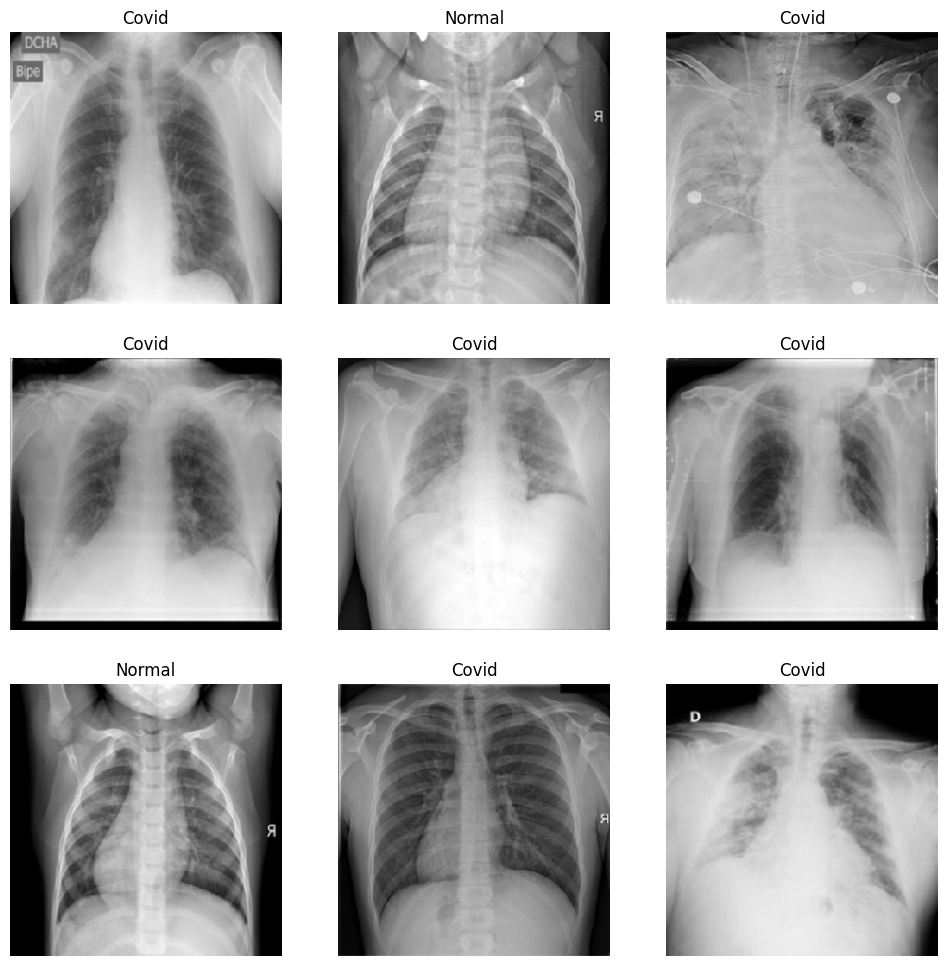

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3,3, i+1)
    img, label = train_generator.next()
    plt.imshow(img[0], cmap='gray')
    dic = {0:'Covid', 1:'Normal'}
    plt.title(dic.get(np.where(label[0]==1)[0][0]))
    plt.axis('off')
plt.show()

In [ ]:
# Function for building a sequential model based off of VGG16 architecture

def covid_model(IMG_SIZE):
    input_shape = IMG_SIZE + (1, )
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding='same',input_shape=input_shape),
        MaxPooling2D(pool_size = (2, 2)), 
        Conv2D(32, (3, 3), padding='same', activation="relu"),
        MaxPooling2D(pool_size = (2, 2)), 
        Conv2D(64, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(64, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(128, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(128, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(128, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(256, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Flatten(),
       
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=2, activation='softmax')
    ])
    return model

In [ ]:
train_model = covid_model(IMG_SIZE)

In [ ]:
train_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

In [ ]:
base_learning_rate = 0.001
opt = Adam(learning_rate=base_learning_rate)
train_model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
initial_epochs = 15
history = train_model.fit(train_generator, epochs=initial_epochs, 
                    validation_data = validation_generator, callbacks=[early_stopping])

Epoch 1/15
181/181 [==============================] - 39s 210ms/step - loss: 0.6812 - accuracy: 0.5421 - val_loss: 0.6589 - val_accuracy: 0.5805
Epoch 2/15
181/181 [==============================] - 21s 114ms/step - loss: 0.5783 - accuracy: 0.6968 - val_loss: 0.5523 - val_accuracy: 0.7498
Epoch 3/15
181/181 [==============================] - 21s 115ms/step - loss: 0.4049 - accuracy: 0.8292 - val_loss: 0.3759 - val_accuracy: 0.8473
Epoch 4/15
181/181 [==============================] - 21s 116ms/step - loss: 0.2757 - accuracy: 0.8902 - val_loss: 0.2967 - val_accuracy: 0.8887
Epoch 5/15
181/181 [==============================] - 21s 116ms/step - loss: 0.2232 - accuracy: 0.9144 - val_loss: 0.2090 - val_accuracy: 0.9274
Epoch 6/15
181/181 [==============================] - 21s 116ms/step - loss: 0.1745 - accuracy: 0.9307 - val_loss: 0.1993 - val_accuracy: 0.9267
Epoch 7/15
181/181 [==============================] - 21s 117ms/step - loss: 0.1551 - accuracy: 0.9402 - val_loss: 0.1955 - val_ac

## Model Evaluation

In [ ]:
# Evaluate the model by getting its final loss and accuracy
train_model.evaluate(validation_generator)

46/46 [==============================] - 2s 42ms/step - loss: 0.1324 - accuracy: 0.9523


[0.13239526748657227, 0.9523151516914368]

In [ ]:
# Create history for loss and accuracy function
def plot_loss_acc(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(train_loss))

    plt.figure(figsize=(8,6))
    plt.plot(epochs, train_loss, color='b', label='Train')
    plt.plot(epochs, val_loss, color='r', label='Validation')
    plt.legend()
    plt.title('Loss')
    
    
    plt.figure(figsize=(8,6))
    plt.plot(epochs, acc, color='b', label='Train')
    plt.plot(epochs, val_acc, color='r', label='Validation')
    plt.legend()
    plt.title('Accuracy')
    
    plt.show()

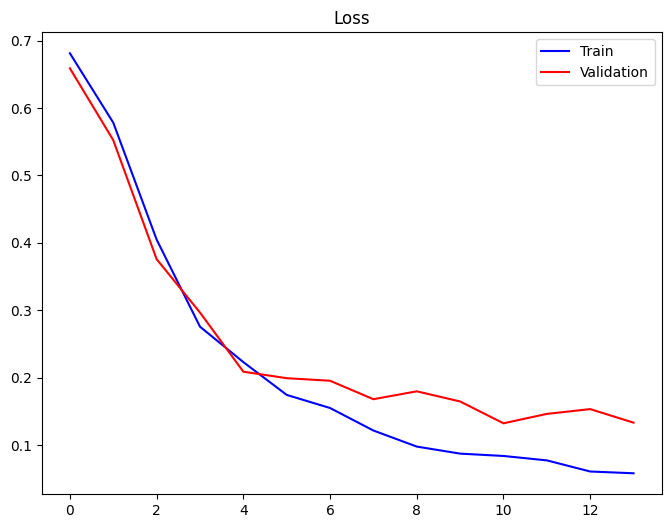

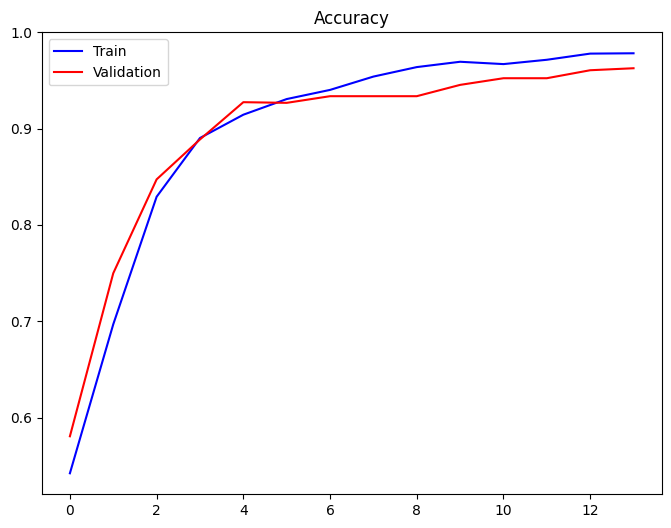

In [ ]:
plot_loss_acc(history)

## Classification Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# predict classes of validation dataset
val_predict = train_model.predict(validation_generator)

46/46 [==============================] - 2s 48ms/step


In [ ]:
predict_class = np.argmax(val_predict, axis=1)
predict_class = predict_class.tolist()

In [ ]:
# Printing out the precision, recall, f1-score and support for the validation dataset

labels = ['Covid', 'Normal']
report = classification_report(validation_generator.classes, predict_class, target_names=labels)
print(report)

              precision    recall  f1-score   support

       Covid       0.95      0.95      0.95       723
      Normal       0.95      0.95      0.95       724

    accuracy                           0.95      1447
   macro avg       0.95      0.95      0.95      1447
weighted avg       0.95      0.95      0.95      1447



In [ ]:
cm = confusion_matrix(validation_generator.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['COVID','NORMAL'], 
                     columns = ['COVID','NORMAL'])

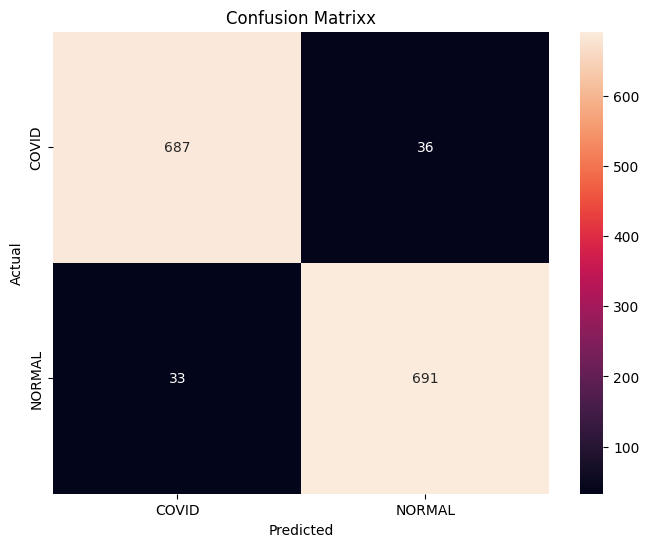

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()